# Calculating correlations between landscape wetness and stream gauges <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the NCI and DEA Sandbox environments. 
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.dea.ga.gov.au/ga_ls9c_ard_3)

## Background
Understanding the movement of floodwater throughout the landscape is critical to managing and tracking water in our important river basins. 
Water is often injected into a region to support agriculture and the environment, but it can be difficult to understand whether this water made it to its intended location. 
Direct measurements of water inundation and flooding are not usually available. 
Developing this understanding is especially important in the dry Australian climate.

### Digital Earth Australia use case
Earth observation data could help track floodwater moving throughout the landscape. Methods like [Tasseled-Cap Wetness (TCW)](https://doi.org/10.1109/TGRS.1984.350619) and [Water Observations from Space (WOfS)](https://doi.org/10.1016/j.rse.2015.11.003) can be used to estimate coverage of water in the landscape from satellite imagery, and this could be used both to build models on water distribution as well as track historical water movements.

### Description
Tracking floodwater is hard though as satellite data are not always available and the flow of water through the landscape can be very complicated. 
It would be really nice if we could use stream gauges as a proxy for floodwater levels away from the streams they probe. 
Stream gauge data are readily available for many rivers and streams throughout the continent, and the data are well-sampled and reliable. 
This notebook estimates the linear correlation between TCW at a location and the height of nearby stream gauges. 
The hope is that by finding such correlations, stream gauge data could be used to provide insights into the spatial footprint of flood events.

## Getting started

Set the analysis parameters and then run all cells.

In [1]:
import datacube
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "../Tools/")
from dea_tools.bom import get_stations, get_station_data
from dea_tools.datahandling import load_ard
from dea_tools.temporal import xr_regression
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
create_local_dask_cluster()

/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33481 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33481/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33481/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40281,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33481/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:40173,Total threads: 2
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/38629/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:37997,


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Wetness_stream_gauge_correlations")

### Analysis parameters

Specify a region to analyse:

In [3]:
# Murray @ Colignan
southwest = -34.58, 142.39
northeast = -34.55, 142.43

# Murray @ Gulpa
# southwest = -35.87, 144.96
# northeast = -35.84, 145.03

ylim, xlim = zip(southwest, northeast)

## Querying the BOM

The Bureau of Meteorology keeps stream gauge data. Get all stream gauge stations:

In [4]:
stations = get_stations()
assert stations, 'No stations retrieved from BOM'

Then find all the stations in our analysis region:

In [5]:
stations_in_range = [
    s for s in stations
    if s.pos and ylim[0] <= s.pos[0] <= ylim[1] and xlim[0] <= s.pos[1] <= xlim[1]
]

In [6]:
print('Found', len(stations_in_range), f'station{"s" if len(stations_in_range) != 1 else ""} in range')

Found 2 stations in range


Get stream data for each station:

In [7]:
station_data = [get_station_data(s) for s in stations_in_range]

Filter out stations without any data:

In [8]:
stations_in_range = [s for d, s in zip(station_data, stations_in_range) if len(d.index)]
station_data = [d for d in station_data if len(d.index)]
print('Found', len(stations_in_range), f'station{"s" if len(stations_in_range) != 1 else ""} with data')

Found 2 stations with data


Then interpolate each gauge to daily.

In [9]:
station_data = [d.resample("1D").mean() for d in station_data]

Find the most recent first observation amongst all stations, then then crop every data series to that

In [10]:
latest_start = max(d.index.min() for d in station_data)
station_data = [d[d.index >= latest_start] for d in station_data]

Now all stations have data over the same time range.

## Load Tasselled Cap Wetness data 

Tasselled Cap Wetness (TCW) is good at detecting water when mixed with vegetation, and we expect wet vegetation on floodplains.

Load a decade of Landsat data so we can calculate TCW. 

> **Note**: This step may take several minutes to complete.
To view how this the load is progressing, click the `dask` client dashboard link under the Getting Started section (e.g. `/user/username/proxy/8787/status`)

In [11]:
ls = load_ard(
    dc,
    products=["ga_ls5t_ard_3", "ga_ls7e_ard_3", "ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    time=("2010", "2020"),
    min_gooddata=0.99,
    x=xlim,
    y=ylim,
    resolution=(-30, 30),
    resampling="average",
    measurements=[
        "nbart_red",
        "nbart_blue",
        "nbart_green",
        "nbart_nir",
        "nbart_swir_1",
        "nbart_swir_2",
    ],
    dask_chunks={"time": 1, "x": 2048, "y": 2048},
).load()

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 104 out of 413 time steps with at least 99.0% good quality pixels
Applying fmask pixel quality/cloud mask
Returning 104 time steps as a dask array


Then calculate TCW:

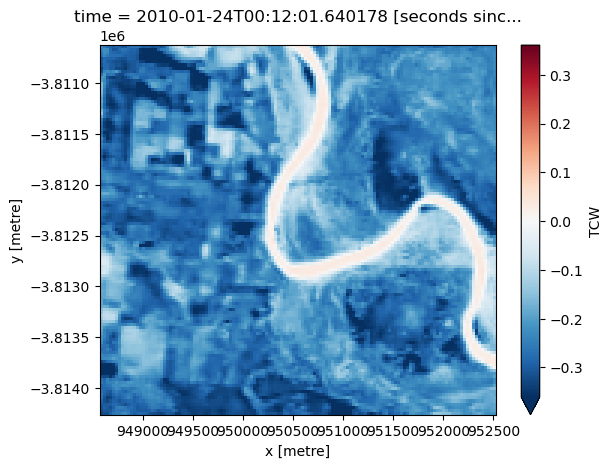

In [12]:
tcw = calculate_indices(ls, "TCW", "ga_ls_3")
tcw.TCW.isel(time=0).plot(robust=True)

### Reindex the stream gauge data to the TCW data

Convert the stream gauge data to `xarray.DataArray` format, then align with the TCW data by reindexing them so their dates match:

In [13]:
station_data_xr = []
for i in range(len(station_data)):
    station_data_xr.append(
        (station_data[i].Value
         .rename_axis("time")
         .to_xarray()
         .interp(time=tcw.time, method="nearest"))
    )

### Normalise the TCW and stream gauge data

Prepare the data for correlation estimation.

Divide the stream gauges by their maximum values to limit their range from 0 to 1:

In [14]:
station_data_xr = [d / d.max() for d in station_data_xr]

Repeat for the TCW data:

In [15]:
tcw_values = tcw.TCW
tcw_values = tcw_values / abs(tcw_values).max(axis=0)

## Regression between each time series

Compute a linear regression between the stream gauge and TCW time series for each gauge and each pixel.


In [16]:
lr = [xr_regression(d, tcw_values) for d in station_data_xr]

Then we can plot the correlations:

In [17]:
station_locations = gpd.GeoDataFrame(
    geometry=[shapely.geometry.Point(s.pos[::-1]) for s in stations_in_range],
    crs="EPSG:4326",
).to_crs(tcw.crs)

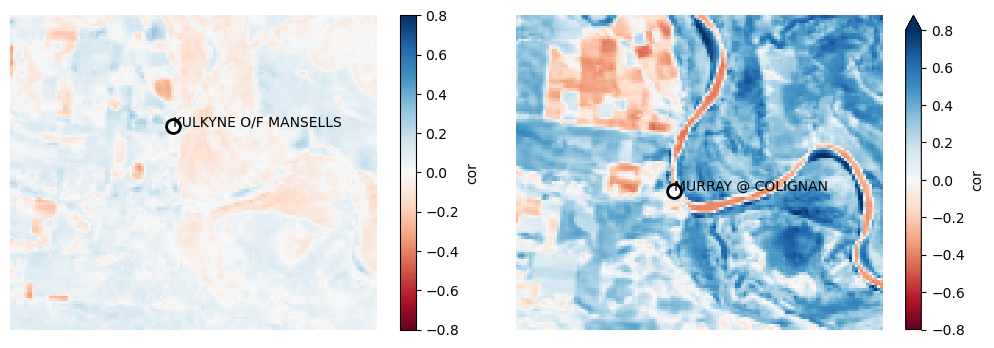

In [18]:
def plot_station_correlations(
    values, vmin=-0.8, vmax=0.8, cmap="RdBu", font_colour="black"
):
    plt.figure(figsize=(15, 20))
    for i in range(len(station_data)):
        ax = plt.subplot(6, 3, i + 1)
        values[i].drop_vars("spatial_ref").plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.scatter(
            station_locations.iloc[i].geometry.x,
            station_locations.iloc[i].geometry.y,
            edgecolor="k",
            facecolor="w",
            s=100,
            linewidth=2,
        )
        ax.axis("off")
        ax.text(
            station_locations.iloc[i].geometry.x,
            station_locations.iloc[i].geometry.y,
            stations_in_range[i].name,
            c=font_colour,
        )
    plt.tight_layout()


plot_station_correlations([l.cor for l in lr])

There are two stream gauges in this region. 
One is off-stream and one is on-stream. 
The on-stream gauge (on the right) appears to be clearly related to the TCW values across the study area's floodplain.

## Estimate which correlations are significant

The `xr_regression` function returns `pvalue` data that indicates whether the linear relationship between TCW and stream gauge height is statistically significant at each pixel. 

For example, we can view the subset of pixels with a significant relationship to stream gauge height at the `p < 0.01` significance level only:

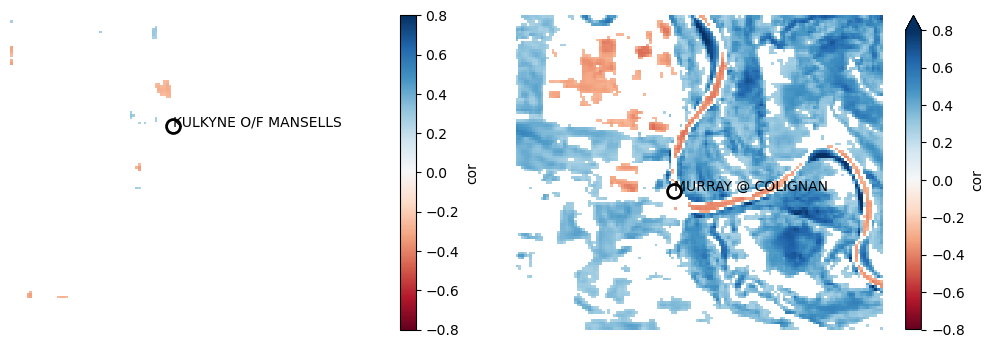

In [19]:
plot_station_correlations(
    [l.cor.where(l.pvalue < 0.01) for l in lr]
)

The detected correlations for the on-stream gauge (right) seem significant, with higher water levels associated with higher wetness across much of the study area's floodplain.

## Conclusion

This is a very simple way of estimating the correlation between stream gauges and the surrounding landscape. Future work should investigate non-linear correlations, potential lag between stream gauges and landscape changes, and merging together identical or near-identical stream gauges (e.g. neighbouring gauges on the same river).

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2024

**Compatible datacube version:**

In [20]:
datacube.__version__

'1.8.18'

## Tags